# Plot Saved Network 

Notebook to plot diagnostics about a previously saved network and its predictions.

By default, this will load the network/prediction results used for generating the `Figure 3` in the paper and generate this figure. 
You can change the network location to load a network that you have generated using the notebook `2 - Train, Test, Save Network.ipynb`.

In [1]:
import sys
sys.path.append('../src')
import os
from classifier import Classifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from utils.mnist_reader import load_train_test_dataset
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

## Load a previously saved network

You can change the network location to load a network that you have generated using the notebook `2 - Train, Test, Save Network.ipynb`.

In [2]:
networks_dir = '../simulation_results/paper_results/pre_trained_network_examples'
network_name = 'r_025_h_0250'

classifier, labels_learnt = Classifier.from_saved(networks_dir+os.sep+network_name, verbose=False)
all_results = classifier.get_last_predict_results()
y_test = all_results['actual']
predictions = all_results['predictions']

Reading network from ../simulation_results/paper_results/pre_trained_network_examples/r_025_h_0250
****** FUll file path for excel  ../simulation_results/paper_results/pre_trained_network_examples/r_025_h_0250/network_description.xlsx
Classifier network defined as follows:

Learning params summary: 
{   'f_h_sparsity': 0.2,
    'h_threshold_mean': 24.0,
    'h_threshold_sd': 3.5,
    'h_weights_d': 0.4,
    'h_weights_init': 1.0,
    'h_weights_p': 0.4,
    'learning_pool_size': 250.0,
    'noise_tolerance_ratio': 1.3,
    'novelty_threshold': 25.0,
    'p_deprecate': 0.02,
    'p_init': 0.5,
    'p_mature_threshold': 1.0,
    'p_potentiate': 0.2,
    'replenish_learning_pool': 1.0}


## Generate Figure 3 Plots

The following cell generates plots for the network and its predictions similar to those in the paper. 

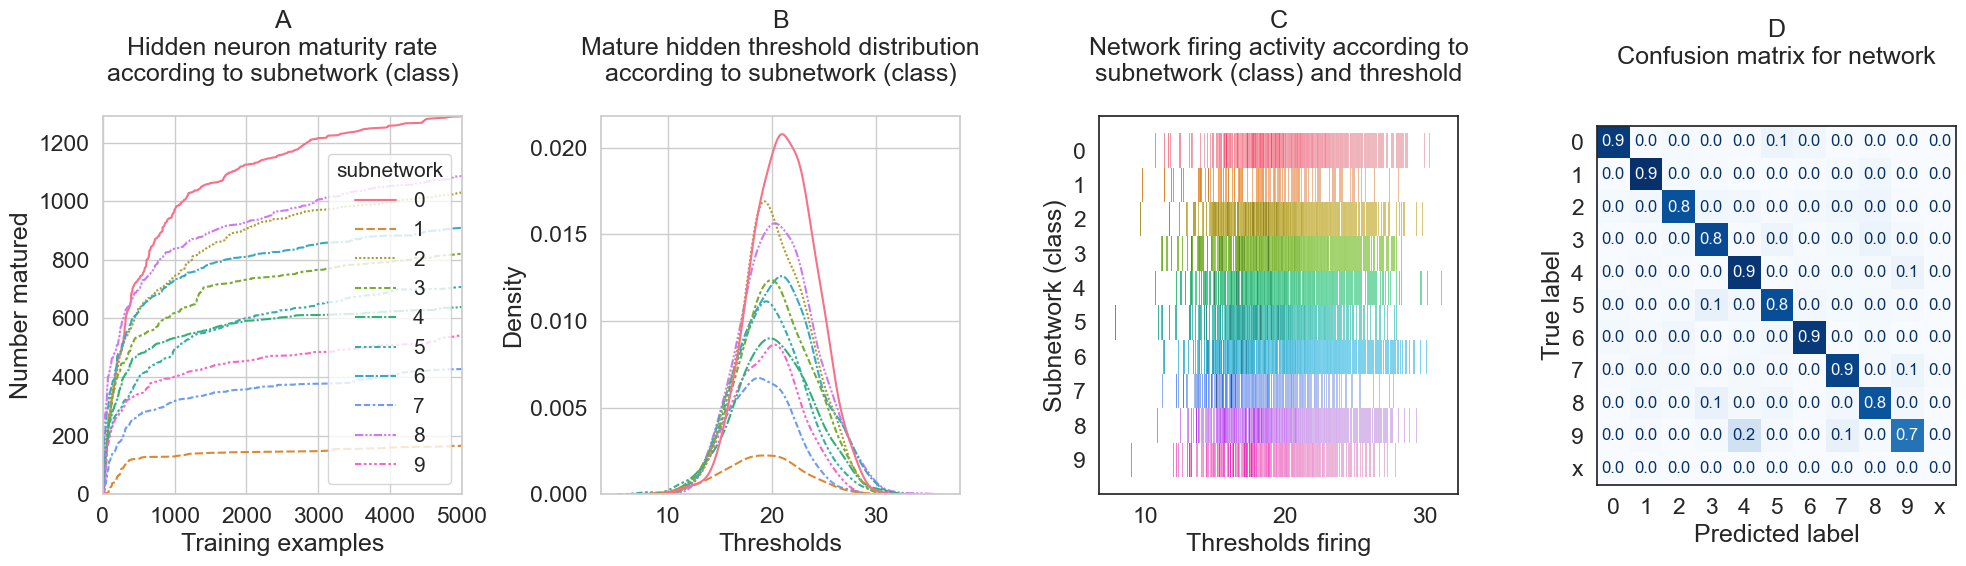

In [5]:
colours = sns.color_palette("husl", len(labels_learnt))

fig = plt.figure(figsize=(20,6))

sns.set(font_scale=1.5, style='whitegrid')
legend_outside_subplot = False

ax1 = fig.add_subplot(141)
ax2 = fig.add_subplot(142)
with sns.axes_style('white'):
    ax3 = fig.add_subplot(143)
    ax4 = fig.add_subplot(144)
# ---------------------------------------------------------------------------------------------------------
# Learning: Number matured per subnet plot
# ---------------------------------------------------------------------------------------------------------
matured, refreshed = classifier.get_training_diagnostics_all_subnets()
x_data = 'training samples'
y_data = 'number matured'

p1 = sns.lineplot(data=matured, hue='Subnetwork', x=x_data, y=y_data, legend=True, palette=colours, style='Subnetwork', ax=ax1)

title = 'A\nHidden neuron maturity rate\naccording to subnetwork (class)'
ax1.set_title(title+'\n')
ax1.set_ylim(np.min(matured[y_data]), np.max(matured[y_data]))
ax1.set_xlim(np.min(matured[x_data]), np.max(matured[x_data]))
ax1.set_xlabel('Training examples')
ax1.set_ylabel('Number matured')
if legend_outside_subplot:
    ax1.set_xticks([0, 2500, 5000])
    ax1.legend(fontsize="small", title='subnetwork', title_fontsize="15", bbox_to_anchor=(1.1, 1.05))
else:
    ax1.legend(fontsize="small", title='subnetwork', title_fontsize="15")
# ---------------------------------------------------------------------------------------------------------
# Learning: Threshold density plot per subnetwork
# ---------------------------------------------------------------------------------------------------------
neuron_data = classifier.h_mature_neuron_data()
all_mature_thresholds = neuron_data['mature_thresholds']
classification = np.empty(shape=(0,), dtype=int)
thresholds = np.empty(shape=(0,), dtype=float)
for subnet_num in np.argsort(labels_learnt):
    subnet_thresholds = all_mature_thresholds[subnet_num][all_mature_thresholds[subnet_num] > 0]
    thresholds = np.append(thresholds, subnet_thresholds)
    classification = np.append(classification, np.repeat(int(labels_learnt[subnet_num]),
                                                         len(subnet_thresholds)))

df = pd.DataFrame(data={'Subnetwork': classification, 'thresholds': thresholds})
p2 = sns.kdeplot(data=df, x="thresholds", hue="Subnetwork", palette=colours, ax=ax2, legend=False)
# -------------------
# sns.kdeplot does not support a 'style' parameter. The following code copies the styles associated with 
# the previous lineplot for consistency across subplots A and B.
# Unfortunately, p1line.get_linestyle() always returns '-' so the protected attribute '_unscaled_dash_pattern'
# has to be used. See: https://stackoverflow.com/questions/38062591/retrieving-custom-dashes-in-matplotlib
# This is a hack and has the risk of deprecation in future matplotlib, in which case the following lines can be removed.
# The code will still work but without the styles.
for p1line, p2line in zip(p1.lines[::-1], p2.lines):
    p2line.set_linestyle(p1line._unscaled_dash_pattern)
# -------------------

title = 'B\nMature hidden threshold distribution\naccording to subnetwork (class)'
ax2.set_title(title+'\n')
ax2.set_xlabel('Thresholds')

# ---------------------------------------------------------------------------------------------------------
# Recall: Thresholds firing per subnet plot
# ---------------------------------------------------------------------------------------------------------
classification = np.empty(shape=(0,), dtype = str)
thresholds_firing = np.empty(shape=(0,), dtype = float)

for subnet_num in np.argsort(labels_learnt):
    firing = classifier.get_thresholds_firing(subnet_num)
    thresholds_firing = np.append(thresholds_firing, firing)
    classification = np.append(classification, np.repeat(labels_learnt[subnet_num], len(firing)))

df2 = pd.DataFrame(data={'Thresholds firing': thresholds_firing, 'Subnetwork (class)': classification})
scatter = sns.histplot(data=df2, x="Thresholds firing", y="Subnetwork (class)",  hue='Subnetwork (class)',
                    palette=colours,
                    legend=False, ax=ax3)
title = 'C\nNetwork firing activity according to\nsubnetwork (class) and threshold'
ax3.set_title(title+'\n')

# ---------------------------------------------------------------------------------------------------------
# Recall: Confusion Matrix
# ---------------------------------------------------------------------------------------------------------
sns.set(font_scale = 1)
ConfusionMatrixDisplay.from_predictions(y_true=y_test, y_pred=predictions,
                                        labels=np.append(np.sort(labels_learnt), 'x'),
                                        normalize='true', values_format = '.1f', colorbar=False,
                                        cmap=plt.cm.Blues, ax=ax4)
sns.set(font_scale = 1.5)
title = 'D\nConfusion matrix for network\n'
ax4.set_title(title+'\n')

plt.tight_layout()

# Uncomment the following line to save the image
#plt.savefig(networks_dir+os.sep+network_name + os.path.sep + 'single_test_plots.png', dpi=1000)
plt.show()
plt.close()

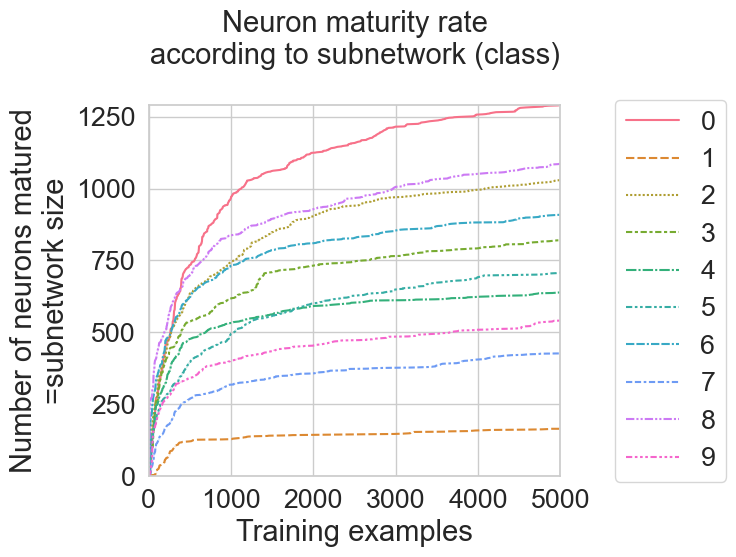

In [4]:
fig = plt.figure(figsize=(8,6))
sns.set(font_scale=1.75, style='whitegrid')
ax1 = fig.add_subplot(111)

# ---------------------------------------------------------------------------------------------------------
# Learning: Number matured per subnet plot
# ---------------------------------------------------------------------------------------------------------
matured, refreshed = classifier.get_training_diagnostics_all_subnets()

x_data = 'training samples'
y_data = 'number matured'
p = sns.lineplot(data=matured, hue='Subnetwork', x=x_data, y=y_data, legend="full", palette=colours, style='Subnetwork', ax=ax1)

title = 'Neuron maturity rate\naccording to subnetwork (class)'
ax1.set_title(title+'\n')

ax1.set_ylim(np.min(matured[y_data]), np.max(matured[y_data]))
ax1.set_xlim(np.min(matured[x_data]), np.max(matured[x_data]))
ax1.set_xlabel('Training examples')
ax1.set_ylabel('Number of neurons matured\n=subnetwork size')
ax1.legend(bbox_to_anchor=(1.1, 1.05))

plt.tight_layout()
# Uncomment the following line to save the image
#plt.savefig(networks_dir+os.sep+network_name + os.path.sep + 'single_test_plot.png', dpi=1000)
plt.show()
plt.close()
